# Pulmonary Fibrosis Starter Notebook

In [1]:
import numpy as np
import pandas as pd

import time

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler
from torch.optim.lr_scheduler import StepLR

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding, get_model_params

from tqdm import tqdm_notebook, tqdm

import pydicom
from glob import glob

from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# check the device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Prepare the Data

To train the model I will fit linear regression models to patient's data and then use deep learning to predict the linear model coefficients.

In [3]:
DATA_DIR = './pulmonary_fibrosis_data/'
TRAIN_DIR = './pulmonary_fibrosis_data/train/'
TEST_DIR = './pulmonary_fibrosis_data/test/'

train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')

In [4]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
patients = train_df.Patient.unique()

In [6]:
patients[:4]

array(['ID00007637202177411956430', 'ID00009637202177434476278',
       'ID00010637202177584971671', 'ID00011637202177653955184'],
      dtype=object)

In [7]:
quantiles = np.array([.6, .4])

def fit_model(model, quantile):
    """Fitting quantile regression model.
    
    Details:
    https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html
    """
    res = model.fit(q=quantile)
    return [quantile, res.params['Intercept'], res.params['Weeks']] + \
            res.conf_int().loc['Weeks'].tolist()

def fit_regression_models(patient_data, quantiles=np.array([.6, .4])):
    """Fit quantile regression models and OLS model."""
    patient_data = patient_data.sort_values(by=['Weeks'], ascending=True)
    x = patient_data['Weeks'].values.reshape(-1,1)
    y = patient_data['FVC'].values.flatten()
    
    model = smf.quantreg('FVC ~ Weeks', patient_data)
    models = [fit_model(model, x) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
    
    ols = smf.ols('FVC ~ Weeks', patient_data).fit()
    ols_ci = ols.conf_int().loc['Weeks'].tolist()
    ols = dict(a = ols.params['Intercept'],
               b = ols.params['Weeks'],
               lb = ols_ci[0],
               ub = ols_ci[1])
    
    models = models.append(ols, ignore_index=True)
    
    return models

In [8]:
patient = patients[np.random.randint(len(patients))]
models = fit_regression_models(train_df[train_df.Patient == patient])

In [9]:
models

,q,a,b,lb,ub
0,0.6,1969.916668,-3.083333,NaN,NaN
1,0.4,2001.266664,-6.133333,NaN,NaN
2,NaN,1984.824680,-4.740104,-8.142709,-1.3375


In [10]:
def lin_func(x, a, b):
    """Linear function."""
    return a + b * x

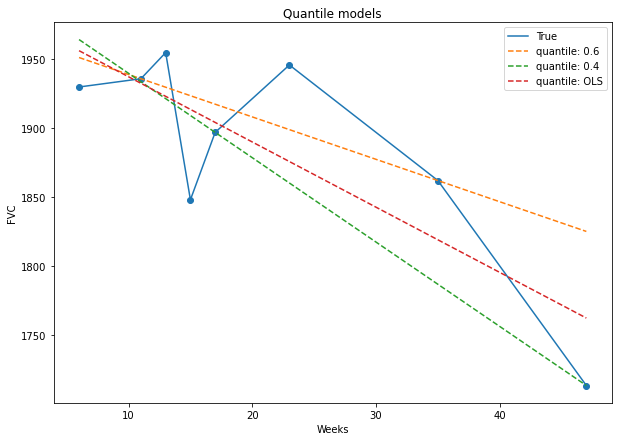

In [11]:
# gets patient's data
patient_data = train_df[train_df.Patient == patient]
patient_data = patient_data.sort_values(by=['Weeks'], ascending=True)
x = patient_data['Weeks'].values.reshape(-1,1)
y = patient_data['FVC'].values.flatten()
    
# plots FVC vs weeks
plt.figure(figsize=(10,7))
plt.title('Quantile models')
plt.plot(x, y, label='True')
plt.scatter(x, y)

# plots quantile and OLS regression results
xs = np.linspace(np.min(x), np.max(x), 20)
for i, row in models.iterrows():
    q = row.q
    a = row.a
    b = row.b
    label = str(q) if str(q)!='nan' else 'OLS'
    plt.plot(x, lin_func(x,a,b), label = 'quantile: ' + label,
            linestyle='--')


plt.xlabel('Weeks')
plt.ylabel('FVC')

plt.legend()
plt.show()

In [12]:
def add_regression_coefficients(train_df, quantiles):
    models_data = pd.DataFrame()
    for patient in patients:
        # Fit the resgrission models
        models = fit_regression_models(train_df[train_df.Patient == patient])
        models['q'] = models['q'].fillna(0.5)
        lower = models[models.q == quantiles[0]]
        upper = models[models.q == quantiles[1]]
        ols = models[models.q == 0.5]
        models_data = models_data.append(
        {
            'Patient': patient,
            'a_lower': lower.a.values[0],
            'a_ols': ols.a.values[0],
            'a_upper': upper.a.values[0],
            'b_lower': lower.b.values[0],
            'b_ols': ols.b.values[0],
            'b_upper': upper.b.values[0],
        }, ignore_index=True)
        
    models_data = models_data.merge(train_df, on=['Patient'])
    return models_data

In [13]:
train_data = add_regression_coefficients(train_df, quantiles)

d:\pycharmprojects\lexie\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
d:\pycharmprojects\lexie\venv\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reac

In [14]:
train_data.head()

,Patient,a_lower,a_ols,a_upper,b_lower,b_ols,b_upper,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,2166.499999,2174.416183,2127.208331,-2.5,-3.167126,-1.541667,11,2069,52.063412,79,Male,Ex-smoker


In [15]:
train_data.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

## Prepare the Datasets for Deep Learning

### Prepare the Data Transforms

In [16]:
# setup image hight and width
HEIGHT = 256
WIDTH = 256
SIZE = 128

# setup the transformations pipelines
def train_transforms(p=.5):
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        albu.HorizontalFlip(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=p),
        albu.Blur(blur_limit=3),
        albu.OpticalDistortion(),
        albu.GridDistortion(),
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

def valid_transforms():
    '''
    Function returns the training pipeline of augmentations
    '''
    return albu.Compose([
        albu.Resize(height = SIZE, width = SIZE)
    ], p=1.0)

In [17]:
train_fns = glob(TRAIN_DIR+'/*/*.dcm')

def visualize_augmentations(n_rows=3, n_cols=3):
    transform = train_transforms(p=.8)
    
    idx = np.random.randint(0, len(train_fns))
    fname = train_fns[idx]
    image = pydicom.read_file(fname).pixel_array
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    for i in range(n_rows):
        for j in range(n_cols):
            
            augmented_image = transform(image=image)['image']

            axs[i,j].imshow(augmented_image, cmap='bone')
            axs[i,j].axis('off')

    plt.suptitle('Examples of augmentations {}'.format(fname.split('/')[-2]))
    plt.show()

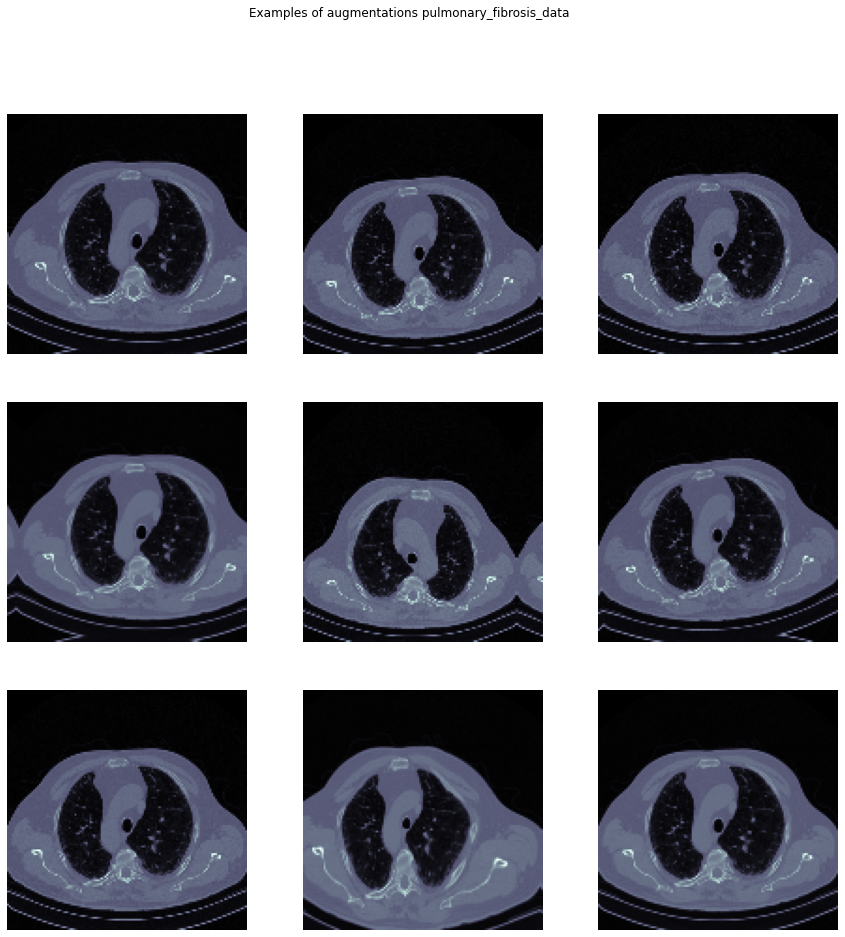

In [18]:
visualize_augmentations()

### Prepare the Dataset

In [19]:
class PulmonaryFibrosisDataset(Dataset):
    '''
    Create custom Pulmonary Fibrosis dataset
    '''
    def __init__(self, data, data_dir, transforms, validation = False):
        self.data = data
        self.data_dir = data_dir
        self.transforms = transforms
        self.validation = validation
        
        self.fns = glob(data_dir + '/*/*.dcm')
        self.n_images = len(self.fns)

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        filename = self.fns[idx]
        if not self.validation:
            
            try:
                image = pydicom.read_file(filename).pixel_array
            except:
                print(filename)
                image = np.zeros((256, 256))
                
            aug = self.transforms(image=image)
            
            patient = filename.split('\\')[-2]
            
            data = self.data[(self.data.Patient == patient)]
            arr = np.array([data['a_lower'].values[0], 
                   data['a_ols'].values[0],
                   data['a_upper'].values[0],
                   data['b_lower'].values[0],
                   data['b_ols'].values[0],
                   data['b_upper'].values[0]])
            age = data['Age'].values[0]
            gender = 1 if data['Sex'].values[0] == 'Male' else 0
            smoking = data['SmokingStatus'].values[0]
            ex_smoker = 0 if smoking == 'Ex-smoker' else 1
            never_smoked = 0 if smoking == 'Never smoked' else 1
                   
            aug_image = aug['image'].astype(float).reshape(1, SIZE, SIZE)
            return torch.tensor(aug_image, dtype=torch.float32), torch.tensor(np.array([age, gender, ex_smoker, never_smoked]).astype(float), dtype=torch.float32), torch.tensor(arr, dtype=torch.float32)
        else:
            image = pydicom.read_file(filename).pixel_array
            aug = self.transforms(image=image)
            
            patient = filename.split('\\')[-2]
            data = self.data[(self.data.Patient == patient)]
            
            age = data['Age'].values[0]
            gender = 1 if data['Sex'].values[0] == 'Male' else 0
            smoking = data['SmokingStatus'].values[0]
            ex_smoker = 0 if smoking == 'Ex-smoker' else 1
            never_smoked = 0 if smoking == 'Never smoked' else 1
            aug_image = aug['image'].astype(float).reshape(1, SIZE, SIZE)
            return torch.tensor(aug_image, dtype=torch.float32),  torch.tensor(np.array([age, gender, ex_smoker, never_smoked]).astype(float), dtype=torch.float32), patient

Check samples from the dataset:

In [20]:
train_dataset = PulmonaryFibrosisDataset(train_data, TRAIN_DIR, train_transforms())
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

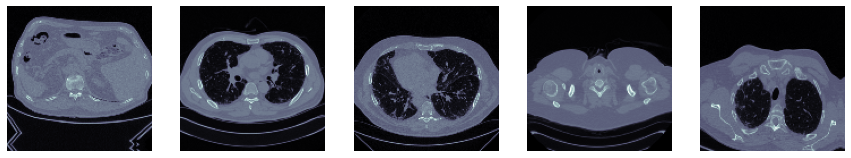

In [21]:
# plot sample train data
for img, meta, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(img[i].reshape(SIZE, SIZE), cmap='bone')
        axs[i].axis('off')
        
    break;

## Define the Model

In [22]:
efficientnet_b0 = EfficientNet.from_name('efficientnet-b0')

In [23]:
class PulmonaryFibrosisModel(nn.Module):
    def __init__(self, backbone_model):
        super(PulmonaryFibrosisModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=1000, out_features=164)
        self.fc2 = nn.Linear(in_features=168, out_features=6)
        
    def forward(self, x, meta):
        # pass through the backbone model
        y = self.conv(x)
        y = self.backbone_model(y)
        y = F.relu(self.fc1(y))
        
        y = torch.cat([y, meta], dim=1)
        y = self.fc2(y)
        
        return y

In [24]:
model = PulmonaryFibrosisModel(efficientnet_b0)

## Setup Training

In [25]:
test_split = 0.2
batch_size = 32
epochs = 100
learning_rate = 0.0001
num_workers = 0

In [26]:
dataset_size = len(train_dataset)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=128, sampler=test_sampler, num_workers=num_workers)

In [27]:
# set loss function
criterion = nn.MSELoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [28]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss','Test loss',
                                     'Learning Rate'])

In [30]:
#train the model
model = model.to(device)

In [32]:
steps = 0
running_loss = 0
model.train()
for epoch in range(epochs):
    
    since = time.time()
    
    for inputs, metas, labels in tqdm_notebook(trainloader):
        steps += 1
        # Move input and label tensors to the default device
        inputs, metas, labels = inputs.to(device), metas.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        preds  = model.forward(inputs, metas)
        loss = criterion(preds, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        
    scheduler.step()
    time_elapsed = time.time() - since
    
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, metas, labels in testloader:
            inputs, metas, labels = inputs.to(device), metas.to(device), labels.to(device)
            
            preds  = model.forward(inputs, metas)
            batch_loss = criterion(preds, labels)
        
            test_loss += batch_loss.item()
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Learning Rate:{scheduler.get_lr()}..")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed,
                                      'Avg time per step': time_elapsed/len(trainloader),
                                      'Train loss' : running_loss/len(trainloader),
                                      'Test loss' : test_loss/len(testloader),
                                      'Learning Rate' : scheduler.get_lr()}, ignore_index=True)

    running_loss = 0
    steps = 0
    model.train()

d:\pycharmprojects\lexie\venv\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Epoch 1/100.. Time per epoch: 183.1973.. Average time per step: 0.2221.. Train loss: 443917.2264.. Test loss: 323266.8618.. Learning Rate:[0.0001]..


d:\pycharmprojects\lexie\venv\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



Epoch 2/100.. Time per epoch: 171.0283.. Average time per step: 0.2073.. Train loss: 309894.7179.. Test loss: 291661.1286.. Learning Rate:[0.0001]..



Epoch 3/100.. Time per epoch: 173.3473.. Average time per step: 0.2101.. Train loss: 268415.0966.. Test loss: 275399.2413.. Learning Rate:[0.0001]..



Epoch 4/100.. Time per epoch: 174.2981.. Average time per step: 0.2113.. Train loss: 237229.1630.. Test loss: 212559.5033.. Learning Rate:[0.0001]..



Epoch 5/100.. Time per epoch: 171.6635.. Average time per step: 0.2081.. Train loss: 210276.2796.. Test loss: 193121.2665.. Learning Rate:[0.0001]..



Epoch 6/100.. Time per epoch: 171.4251.. Average time per step: 0.2078.. Train loss: 185466.0442.. Test loss: 153343.8427.. Learning Rate:[0.0001]..



Epoch 7/100.. Time per epoch: 170.4483.. Average time per step: 0.2066.. Train loss: 169921.1477.. Test loss: 125425.9477.. Learning Rate:[0.0001]..



Epoch 8/100.. Time per epoch: 170.9800.. Average time per step: 0.2072.. Train loss: 150049.4331.. Test loss: 119152.2598.. Learning Rate:[0.0001]..



Epoch 12/100.. Time per epoch: 172.1443.. Average time per step: 0.2087.. Train loss: 100953.7051.. Test loss: 81964.8842.. Learning Rate:[0.0001]..



Epoch 13/100.. Time per epoch: 171.5612.. Average time per step: 0.2080.. Train loss: 92965.0693.. Test loss: 81541.2023.. Learning Rate:[0.0001]..



Epoch 14/100.. Time per epoch: 171.3326.. Average time per step: 0.2077.. Train loss: 87130.6680.. Test loss: 59608.7980.. Learning Rate:[0.0001]..



Epoch 15/100.. Time per epoch: 173.0245.. Average time per step: 0.2097.. Train loss: 80304.4252.. Test loss: 66386.8510.. Learning Rate:[0.0001]..



Epoch 16/100.. Time per epoch: 170.4088.. Average time per step: 0.2066.. Train loss: 71305.9767.. Test loss: 54334.4751.. Learning Rate:[0.0001]..



Epoch 17/100.. Time per epoch: 171.0085.. Average time per step: 0.2073.. Train loss: 71167.8090.. Test loss: 65189.2613.. Learning Rate:[0.0001]..



Epoch 18/100.. Time per epoch: 170.5733.. Average time per step: 0.2068.. Train loss: 64916.2542.. Test loss: 43994.3806.. Learning Rate:[0.0001]..



Epoch 19/100.. Time per epoch: 170.8089.. Average time per step: 0.2070.. Train loss: 63154.1161.. Test loss: 42658.3925.. Learning Rate:[2.5e-05]..



Epoch 20/100.. Time per epoch: 170.4973.. Average time per step: 0.2067.. Train loss: 50998.7119.. Test loss: 32337.0282.. Learning Rate:[5e-05]..



Epoch 21/100.. Time per epoch: 170.8485.. Average time per step: 0.2071.. Train loss: 46678.1472.. Test loss: 39979.3526.. Learning Rate:[5e-05]..



Epoch 22/100.. Time per epoch: 170.7924.. Average time per step: 0.2070.. Train loss: 45319.6759.. Test loss: 31514.9387.. Learning Rate:[5e-05]..



Epoch 23/100.. Time per epoch: 170.2047.. Average time per step: 0.2063.. Train loss: 44355.3462.. Test loss: 36130.0670.. Learning Rate:[5e-05]..



Epoch 24/100.. Time per epoch: 170.6066.. Average time per step: 0.2068.. Train loss: 44020.6757.. Test loss: 30380.2262.. Learning Rate:[5e-05]..



Epoch 25/100.. Time per epoch: 170.8318.. Average time per step: 0.2071.. Train loss: 39671.5190.. Test loss: 30258.2918.. Learning Rate:[5e-05]..



Epoch 26/100.. Time per epoch: 170.7917.. Average time per step: 0.2070.. Train loss: 38760.6501.. Test loss: 33994.3558.. Learning Rate:[5e-05]..



Epoch 27/100.. Time per epoch: 170.2440.. Average time per step: 0.2064.. Train loss: 39912.8021.. Test loss: 30394.8864.. Learning Rate:[5e-05]..



Epoch 28/100.. Time per epoch: 170.2479.. Average time per step: 0.2064.. Train loss: 36887.8444.. Test loss: 27890.7449.. Learning Rate:[5e-05]..



Epoch 29/100.. Time per epoch: 170.5720.. Average time per step: 0.2068.. Train loss: 36078.9641.. Test loss: 26167.4841.. Learning Rate:[5e-05]..



Epoch 30/100.. Time per epoch: 170.2259.. Average time per step: 0.2063.. Train loss: 36317.1170.. Test loss: 26424.9506.. Learning Rate:[5e-05]..



Epoch 31/100.. Time per epoch: 170.8376.. Average time per step: 0.2071.. Train loss: 34631.5180.. Test loss: 23650.4476.. Learning Rate:[5e-05]..



Epoch 32/100.. Time per epoch: 170.7155.. Average time per step: 0.2069.. Train loss: 32624.6069.. Test loss: 22671.8929.. Learning Rate:[5e-05]..



Epoch 33/100.. Time per epoch: 170.2899.. Average time per step: 0.2064.. Train loss: 34392.4522.. Test loss: 25101.4128.. Learning Rate:[5e-05]..



Epoch 34/100.. Time per epoch: 170.0171.. Average time per step: 0.2061.. Train loss: 32432.6167.. Test loss: 27263.3166.. Learning Rate:[5e-05]..



Epoch 35/100.. Time per epoch: 170.2624.. Average time per step: 0.2064.. Train loss: 31095.6825.. Test loss: 21074.8275.. Learning Rate:[5e-05]..



Epoch 36/100.. Time per epoch: 170.4324.. Average time per step: 0.2066.. Train loss: 31253.8896.. Test loss: 20597.7459.. Learning Rate:[5e-05]..



Epoch 37/100.. Time per epoch: 170.5233.. Average time per step: 0.2067.. Train loss: 29171.3626.. Test loss: 19153.1177.. Learning Rate:[5e-05]..



Epoch 38/100.. Time per epoch: 170.2919.. Average time per step: 0.2064.. Train loss: 28815.7999.. Test loss: 21876.0639.. Learning Rate:[5e-05]..



Epoch 39/100.. Time per epoch: 169.4309.. Average time per step: 0.2054.. Train loss: 28294.1040.. Test loss: 23891.3239.. Learning Rate:[1.25e-05]..



Epoch 40/100.. Time per epoch: 182.4278.. Average time per step: 0.2211.. Train loss: 26040.1134.. Test loss: 15336.6045.. Learning Rate:[2.5e-05]..



Epoch 41/100.. Time per epoch: 185.8497.. Average time per step: 0.2253.. Train loss: 23550.4422.. Test loss: 17169.8791.. Learning Rate:[2.5e-05]..



Epoch 42/100.. Time per epoch: 176.4328.. Average time per step: 0.2139.. Train loss: 24167.5706.. Test loss: 15183.9617.. Learning Rate:[2.5e-05]..



Epoch 43/100.. Time per epoch: 171.6127.. Average time per step: 0.2080.. Train loss: 23476.8757.. Test loss: 14763.6885.. Learning Rate:[2.5e-05]..



Epoch 44/100.. Time per epoch: 171.9568.. Average time per step: 0.2084.. Train loss: 22917.5073.. Test loss: 13276.2956.. Learning Rate:[2.5e-05]..


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 51/100.. Time per epoch: 171.0413.. Average time per step: 0.2073.. Train loss: 20279.1981.. Test loss: 12688.6449.. Learning Rate:[2.5e-05]..


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 59/100.. Time per epoch: 172.7905.. Average time per step: 0.2094.. Train loss: 19305.9060.. Test loss: 11475.8747.. Learning Rate:[6.25e-06]..


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 66/100.. Time per epoch: 171.5941.. Average time per step: 0.2080.. Train loss: 16234.4976.. Test loss: 9531.4069.. Learning Rate:[1.25e-05]..



Epoch 67/100.. Time per epoch: 170.9998.. Average time per step: 0.2073.. Train loss: 15699.1770.. Test loss: 10589.8869.. Learning Rate:[1.25e-05]..


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 74/100.. Time per epoch: 170.7840.. Average time per step: 0.2070.. Train loss: 15248.4817.. Test loss: 9837.6794.. Learning Rate:[1.25e-05]..



Epoch 75/100.. Time per epoch: 173.3666.. Average time per step: 0.2101.. Train loss: 14363.5780.. Test loss: 10503.3636.. Learning Rate:[1.25e-05]..


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 81/100.. Time per epoch: 172.1921.. Average time per step: 0.2087.. Train loss: 14287.4982.. Test loss: 9045.2881.. Learning Rate:[6.25e-06]..



Epoch 82/100.. Time per epoch: 175.4096.. Average time per step: 0.2126.. Train loss: 13655.0349.. Test loss: 9537.8703.. Learning Rate:[6.25e-06]..



Epoch 83/100.. Time per epoch: 171.3686.. Average time per step: 0.2077.. Train loss: 13498.4368.. Test loss: 7784.7533.. Learning Rate:[6.25e-06]..



Epoch 84/100.. Time per epoch: 170.3769.. Average time per step: 0.2065.. Train loss: 13201.7273.. Test loss: 8263.5884.. Learning Rate:[6.25e-06]..



Epoch 85/100.. Time per epoch: 170.0308.. Average time per step: 0.2061.. Train loss: 13470.0306.. Test loss: 8696.2288.. Learning Rate:[6.25e-06]..



Epoch 86/100.. Time per epoch: 175.5642.. Average time per step: 0.2128.. Train loss: 13492.3682.. Test loss: 8241.5431.. Learning Rate:[6.25e-06]..



Epoch 87/100.. Time per epoch: 172.3859.. Average time per step: 0.2090.. Train loss: 13537.0975.. Test loss: 8040.6194.. Learning Rate:[6.25e-06]..



Epoch 88/100.. Time per epoch: 170.7376.. Average time per step: 0.2070.. Train loss: 13313.4472.. Test loss: 8310.2946.. Learning Rate:[6.25e-06]..



Epoch 89/100.. Time per epoch: 171.9134.. Average time per step: 0.2084.. Train loss: 13707.0506.. Test loss: 8892.3682.. Learning Rate:[6.25e-06]..



Epoch 90/100.. Time per epoch: 170.9450.. Average time per step: 0.2072.. Train loss: 13844.5616.. Test loss: 9360.9529.. Learning Rate:[6.25e-06]..



Epoch 91/100.. Time per epoch: 173.5290.. Average time per step: 0.2103.. Train loss: 13956.9345.. Test loss: 7948.7691.. Learning Rate:[6.25e-06]..



Epoch 92/100.. Time per epoch: 178.5999.. Average time per step: 0.2165.. Train loss: 13312.7012.. Test loss: 9200.2329.. Learning Rate:[6.25e-06]..



Epoch 93/100.. Time per epoch: 177.5895.. Average time per step: 0.2153.. Train loss: 13355.8099.. Test loss: 7407.9265.. Learning Rate:[6.25e-06]..



Epoch 94/100.. Time per epoch: 184.9042.. Average time per step: 0.2241.. Train loss: 13880.7254.. Test loss: 8392.3992.. Learning Rate:[6.25e-06]..



Epoch 95/100.. Time per epoch: 169.7923.. Average time per step: 0.2058.. Train loss: 13165.9218.. Test loss: 8522.4880.. Learning Rate:[6.25e-06]..



Epoch 96/100.. Time per epoch: 169.3495.. Average time per step: 0.2053.. Train loss: 13294.3869.. Test loss: 8724.7394.. Learning Rate:[6.25e-06]..



Epoch 97/100.. Time per epoch: 169.4866.. Average time per step: 0.2054.. Train loss: 12806.4641.. Test loss: 7514.0090.. Learning Rate:[6.25e-06]..



Epoch 98/100.. Time per epoch: 172.3102.. Average time per step: 0.2089.. Train loss: 13149.9117.. Test loss: 8859.2124.. Learning Rate:[6.25e-06]..



Epoch 99/100.. Time per epoch: 169.3870.. Average time per step: 0.2053.. Train loss: 12306.3598.. Test loss: 8396.3577.. Learning Rate:[1.5625e-06]..



Epoch 100/100.. Time per epoch: 170.0838.. Average time per step: 0.2062.. Train loss: 12867.9592.. Test loss: 8199.6812.. Learning Rate:[3.125e-06]..


In [ ]:
train_stats.to_csv('./train_stats_efficient_net_b0_{}.csv'.format(epochs), index=False)

In [ ]:
filename = 'efficientnet_b0_'+ str(epochs) + '.pth'
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, filename)

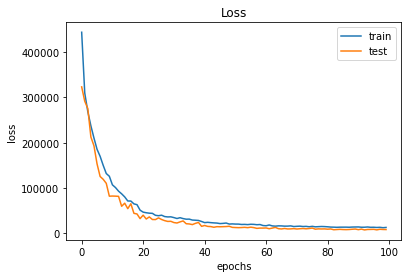

In [ ]:
train_loss = train_stats['Train loss'].values
test_loss = train_stats['Test loss'].values
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')

plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Look at The Predictions

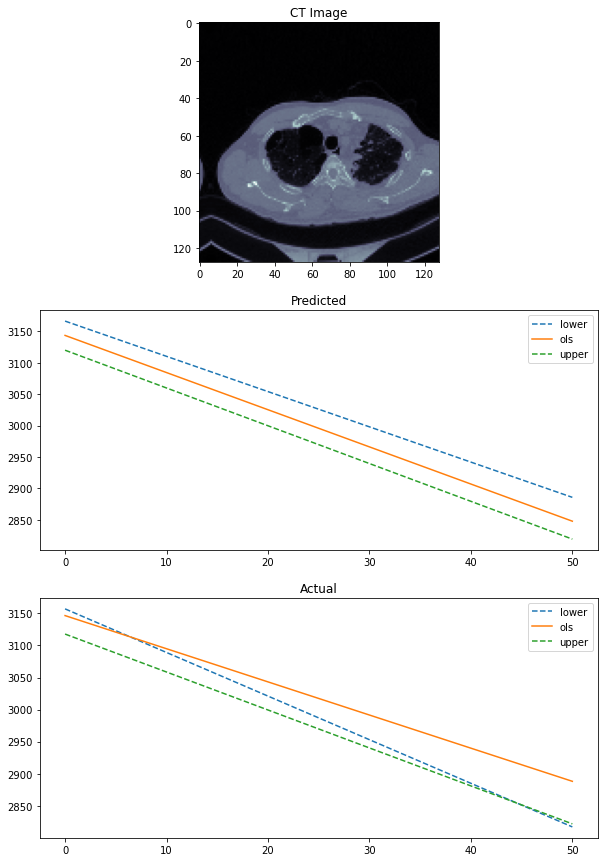

In [42]:
# plot sample train data
model.eval()
for img, meta, labels in testloader:
    img, meta, labels = img.to(device), meta.to(device), labels.to(device)
    preds  = model.forward(img, meta)
    
    img = img.cpu().detach().numpy()
    preds = preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    
    # visualize the inputs
    fig, axs = plt.subplots(3, 1, figsize=(10,15))
    for i in range(0, img.shape[0]):
        axs[0].imshow(img[i].reshape(SIZE, SIZE), cmap='bone')
        axs[0].set_title('CT Image')
        
        # plot predicted prognosis
        a_lower, a_ols, a_upper, b_lower, b_ols, b_upper = preds[i][0], preds[i][1], preds[i][2], preds[i][3], preds[i][4], preds[i][5]
        x = np.linspace(0, 50, 10)
        axs[1].plot(x, lin_func(x,a_lower,b_lower), label = 'lower',
            linestyle='--')
        axs[1].plot(x, lin_func(x,a_ols,b_ols), label = 'ols',
            linestyle='-')
        axs[1].plot(x, lin_func(x,a_upper,b_upper), label = 'upper',
            linestyle='--')
        axs[1].set_title('Predicted')
        axs[1].legend()
        
        # plot actual prognosis   
        a_lower, a_ols, a_upper, b_lower, b_ols, b_upper = labels[i][0], labels[i][1], labels[i][2], labels[i][3], labels[i][4], labels[i][5]
        axs[2].plot(x, lin_func(x,a_lower,b_lower), label = 'lower',
            linestyle='--')
        axs[2].plot(x, lin_func(x,a_ols,b_ols), label = 'ols',
            linestyle='-')
        axs[2].plot(x, lin_func(x,a_upper,b_upper), label = 'upper',
            linestyle='--')
        axs[2].set_title('Actual')
        axs[2].legend()
        
        plt.show()
        break;
        
    break;